In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml
except:
    pass

# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.utils import load_hyperparameters, QFDataset, weizsaecker_pseudo_integrand, weizsaecker_pseudo_functional, weizsaecker_pseudo_functional_derivative, integrate, normalize, anim_plot, save_hdf5, load_hdf5

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 552kB 33.7MB/s 


In [0]:
experiment = 'models/self_consistency'

base_dir = os.path.join(data_dir, experiment)
if not os.path.exists(base_dir): os.makedirs(base_dir)

file_hyperparams = os.path.join(base_dir, "hyperparams.config")
file_model = os.path.join(base_dir, "model.py")

In [0]:
class LocalPCA(tf.Module):
    def __init__(self, X_train, m, l, pseudo=False):
        super().__init__()
        if pseudo:
            self.X_train = tf.Variable(initial_value=np.sqrt(X_train))
        else:
            self.X_train = tf.Variable(initial_value=X_train)
        self.m = tf.Variable(initial_value=m)
        self.l = tf.Variable(initial_value=l)
        self.pseudo = pseudo

    @tf.function
    def projection_subspace(self, X):
        metric = tf.reduce_sum(tf.square(tf.expand_dims(X, axis=2) - tf.expand_dims(tf.transpose(self.X_train), axis=0)), axis=1)
        _, closest_indices = tf.math.top_k(-metric, k=self.m)
        X_closest = tf.gather(self.X_train, closest_indices)

        X_diff = tf.expand_dims(X, axis=1) - X_closest
        C = tf.linalg.matmul(X_diff, X_diff, transpose_a=True)/tf.cast(self.m, X.dtype)

        eigen_vals, eigen_vecs = tf.linalg.eigh(C)
        return eigen_vecs[:, :, -self.l:]

    @tf.function
    def __call__(self, X, functional_derivative):
        projection_subspace = self.projection_subspace(X)
        if self.pseudo:
            X = tf.math.sqrt(X)
        return tf.reduce_sum(tf.linalg.matmul(projection_subspace, tf.linalg.matmul(projection_subspace, tf.expand_dims(functional_derivative, axis=2), transpose_a=True)), axis=-1)


class SelfConsistentDensity(tf.Module):
    def __init__(self, model, vW_model, project_fd, project, params):
        self.model = model
        self.vW_model = vW_model
        self.project_fd = project_fd
        self.project = project
        self.pseudo = params['pseudo_wavefunction']
        self.dtype = params['dtype']
        self.step_size = params['step_size']
        self.iterations = params['iterations']
        self.subtract_von_weizsaecker = params['model_subtract_von_weizsaecker']
        self.model_pseudo_wavefunction = params.get('model_pseudo_wavefunction', False)
        self.model_normalize_features = params.get('model_normalize_features', False)
        self.model_dtype = params['model_dtype']
        self.N = params['N']
        self.h = params['dataset_info']['h']

        self.recordings = {}
        self.record_M = params.get('record_M', 0) 
        self.record = params.get('record', {})   

    @tf.function
    def pseudo_step(self, pseudo, potential):
        density = tf.math.square(pseudo)
        potential_energy = integrate(potential*density, self.h)

        model_input = pseudo if self.model_pseudo_wavefunction else density
        with tf.GradientTape() as tape:
            tape.watch(model_input)
            model_kinetic_energy = self.model({'density': tf.cast(model_input, dtype=self.model_dtype)})['kinetic_energy']
        model_derivative = 1/self.h*tape.gradient(model_kinetic_energy, model_input)
        model_kinetic_energy = tf.cast(model_kinetic_energy, dtype=self.dtype)
        original_model_derivative = tf.cast(model_derivative, dtype=self.dtype)

        if not self.model_pseudo_wavefunction:
            model_derivative = original_model_derivative*2*pseudo

        if self.model_normalize_features:
            model_kinetic_energy *= 6*self.N**2
            model_derivative *= 6*self.N**2
            original_model_derivative *= 6*self.N**2

        with tf.GradientTape() as tape:
            tape.watch(pseudo)
            vW_kinetic_energy = self.vW_model(pseudo)['kinetic_energy']

        vW_derivative = 1/self.h*tape.gradient(vW_kinetic_energy, pseudo)

        derivative = model_derivative + self.subtract_von_weizsaecker*vW_derivative
        kinetic_energy = model_kinetic_energy + self.subtract_von_weizsaecker*vW_kinetic_energy

        vW_mu = 1/float(self.N)*(kinetic_energy + potential_energy)
        potential_derivative = 2*pseudo*(potential - self.subtract_von_weizsaecker*tf.expand_dims(vW_mu, axis=-1))
        functional_derivative = derivative + potential_derivative
        fd = functional_derivative[:, 2:-2]
        functional_derivative = tf.concat([3*fd[:, 0:1] - 2*fd[:, 1:2], 2*fd[:, 0:1] - fd[:, 1:2], fd, 2*fd[:, -1:] - fd[:, -2:-1], 3*fd[:, -1:] - 2*fd[:, -2:-1]], axis=1)

        new_pseudo = pseudo - self.step_size*functional_derivative

        new_pseudo = self.project(new_pseudo)
    
        return new_pseudo, functional_derivative, original_model_derivative, vW_derivative, potential_derivative, kinetic_energy, potential_energy, vW_mu

    @tf.function
    def density_step(self, density, potential):
        potential_energy = integrate(potential*density, self.h)

        with tf.GradientTape() as tape:
            tape.watch(density)
            model_kinetic_energy = self.model({'density': tf.cast(density, dtype=self.model_dtype)})['kinetic_energy']

        model_derivative = 1/self.h*tape.gradient(model_kinetic_energy, density)
        model_kinetic_energy = tf.cast(model_kinetic_energy, dtype=self.dtype)
        model_derivative = tf.cast(model_derivative, dtype=self.dtype)

        with tf.GradientTape() as tape:
            tape.watch(density)
            vW_kinetic_energy = self.vW_model(density)['kinetic_energy']

        vW_derivative = 1/self.h*tape.gradient(vW_kinetic_energy, density)

        derivative = model_derivative + self.subtract_von_weizsaecker*vW_derivative
        kinetic_energy = model_kinetic_energy + self.subtract_von_weizsaecker*vW_kinetic_energy

        vW_mu = 1/float(self.N)*(kinetic_energy + potential_energy)
        potential_derivative = potential - self.subtract_von_weizsaecker*tf.expand_dims(vW_mu, axis=-1)
        functional_derivative = derivative + potential_derivative

        functional_derivative = self.project_fd(density, functional_derivative)
        new_density = density - self.step_size*functional_derivative

        new_density = self.project(new_density)

        return new_density, functional_derivative, model_derivative, vW_derivative, potential_derivative, kinetic_energy, potential_energy, vW_mu

    def step(self, value, potential):
        if self.pseudo:
            return self.pseudo_step(value, potential)
        else:
            return self.density_step(value, potential)

    def train(self, potential, initial_value, progress=None):
        if progress is not None:
            progress.max = self.iterations+1
        
        self.recordings = {}
        for key in self.record.keys():
            self.recordings[key] = []

        value = initial_value
        for i in range(self.iterations+1):
            if progress is not None and i % (self.iterations//100) == 0:
                progress.value = i + 1

            value, functional_derivative, model_derivative, vW_derivative, potential_derivative, kinetic_energy, potential_energy, vW_mu = self.step(value, potential)
            value = tf.debugging.check_numerics(value, message='Invalid value encountered, step {}.'.format(i+1))

            if 'value' in self.record and i % self.record['value'] == 0: self.recordings['value'].append(value.numpy())
            if 'model_derivative' in self.record and i % self.record['model_derivative'] == 0: self.recordings['model_derivative'].append(model_derivative[:self.record_M].numpy())
            if 'vW_derivative' in self.record and i % self.record['vW_derivative'] == 0: self.recordings['vW_derivative'].append(vW_derivative[:self.record_M].numpy())
            if 'functional_derivative' in self.record and i % self.record['functional_derivative'] == 0: self.recordings['functional_derivative'].append(functional_derivative[:self.record_M].numpy())

        return value

    def get_recordings(self):
        for key in self.record.keys():
            self.recordings[key] = np.array(self.recordings[key])
        return self.recordings

    def plot_step(self, dataset, value=None, M=5):
        if value is None:
            value = dataset.pseudo[:M] if self.pseudo else dataset.density[:M]
        else:
            value = value[:M]

        plt.figure(figsize=(20, 3), dpi=dpi)
        plt.plot(dataset.x, tf.transpose(value[:preview]))
        plt.legend(['initial value'])
        plt.show()
        
        value, functional_derivative, model_derivative, vW_derivative, potential_derivative, kinetic_energy, potential_energy, vW_mu = self.step(value, dataset.potential[:M])

        plt.figure(figsize=(20, 3), dpi=dpi)
        plt.plot(dataset.x, tf.transpose(model_derivative[:preview]))
        plt.legend(['model_derivative'])
        plt.show()

        plt.figure(figsize=(20, 3), dpi=dpi)
        plt.plot(dataset.x, tf.transpose(vW_derivative[:preview]))
        plt.legend(['vW_derivative'])
        plt.show()

        plt.figure(figsize=(20, 3), dpi=dpi)
        plt.plot(dataset.x, tf.transpose(potential_derivative[:preview]))
        plt.legend(['potential_derivative'])
        plt.show()

        plt.figure(figsize=(20, 3), dpi=dpi)
        plt.plot(dataset.x, tf.transpose(functional_derivative[:preview]))
        plt.legend(['functional_derivative'])
        plt.show()

    def plot_performance(self, dataset, value=None, batch_size=100):
        if value is None:
            value = dataset.pseudo if self.pseudo else dataset.density

        assert dataset.dataset_size % batch_size == 0, "can't divide dataset into equal parts: {} % {} != 0".format(dataset.dataset_size, batch_size)
        kinetic_energy_list = []
        model_derivative_list = []
        functional_derivative_list = []
        for batch in range(dataset.dataset_size // batch_size):
            _, functional_derivative, model_derivative, _, _, kinetic_energy, _, _ = self.step(value[batch*batch_size:(batch+1)*batch_size], dataset.potential[batch*batch_size:(batch+1)*batch_size])
            kinetic_energy_list.append(kinetic_energy)
            model_derivative_list.append(model_derivative)
            functional_derivative_list.append(functional_derivative)
        
        kinetic_energy = np.concatenate(kinetic_energy_list, axis=0)
        model_derivative = np.concatenate(model_derivative_list, axis=0)
        functional_derivative = np.concatenate(functional_derivative_list, axis=0)

        kenergies_err = (kinetic_energy - dataset.kinetic_energy)*kcalmol_per_hartree
        kenergies_abs_err = np.abs(kenergies_err)
        print('Kinetic Energy:')
        print('MAE:', np.nanmean(kenergies_abs_err))
        print('AE_std:', np.std(kenergies_abs_err))
        print('AE_max:', np.max(kenergies_abs_err))

        plt.figure(figsize=figsize, dpi=dpi)
        plt.hist(kenergies_err, bins=100)
        plt.yscale('log', nonposy='clip')
        plt.title('Kinetic Energy Error')
        plt.xlabel('kcal/mol')
        plt.show()

        if self.pseudo:
            model_derivative += dataset.vW_derivative
        functional_err = (model_derivative - dataset.derivative)
        functional_norm_err = integrate(np.abs(functional_err), dataset.h)*kcalmol_per_hartree

        print('Functional Derivative:')
        print('MAE:', np.nanmean(functional_norm_err))
        print('AE_std:', np.std(functional_norm_err))
        print('AE_max:', np.max(functional_norm_err))

        plt.figure(figsize=figsize, dpi=dpi)
        plt.hist(functional_norm_err, bins=100)
        plt.yscale('log', nonposy='clip')
        plt.title('Functional Derivative Error')
        plt.xlabel('hartree')
        plt.show()

class vWModel():
    @tf.custom_gradient
    def __call__(self, pseudo):
        def grad(kinetic_energy, kinetic_energy_density):
            return 1/499*weizsaecker_pseudo_functional_derivative(pseudo, 1/499)
        return {'kinetic_energy': weizsaecker_pseudo_functional(pseudo, 1/499), 'kinetic_energy_density': weizsaecker_pseudo_integrand(pseudo, 1/499)}, grad


In [6]:
%%writefile $file_hyperparams

default: &DEFAULT
    model: null
    model_dtype: float32

    dataset: datasets/dataset_test.hdf5
    train_dataset: datasets/dataset_paper.hdf5
    batch_size: 100

    N: 1
    dtype: float64
    model_subtract_von_weizsaecker: False
    model_pseudo_wavefunction: False

    initial_density: mean # mean, zeroV

    iterations: 10000
    step_size:  0.0001
    pseudo_wavefunction: False
    project_functional_derivative: null
    project: null

    record_filename: 'recordings.hdf5'
    record_M: 1 # per batch
    record: 
        value: 100
        model_derivative: 100
        vW_derivative: 100
        functional_derivative: 100

pca: &PCA
    pseudo_wavefunction: False
    project_functional_derivative: 'pca'
    project: null
    pca_kwargs: 
        m: 30
        l: 5

    iterations: 1000
    step_size:  0.001
    record: 
        value: 10
        model_derivative: 10
        vW_derivative: 10
        functional_derivative: 10

######################

pure_vW:
    <<: *DEFAULT
    model_subtract_von_weizsaecker: True
    model_von_weizsaecker_factor: 1
    pseudo_wavefunction: True
    model_pseudo_wavefunction: False
    project: 'sines'
    sines_n: 40

krr:
    <<: [*PCA, *DEFAULT]
    model: ke_krr/default/saved_model
    model_dtype: float64

cnn:
    <<: [*PCA, *DEFAULT]
    model: kd_cnn/cnn/seed0/saved_model

models_cnn:
    <<: [*PCA, *DEFAULT]
    model: models/cnn/saved_model

resnet:
    <<: [*PCA, *DEFAULT]
    model: kd_cnn/resnet/seed0/saved_model

models_resnet:
    <<: [*PCA, *DEFAULT]
    model: models/resnet/saved_model

models_resnet_7:
    <<: [*PCA, *DEFAULT]
    model: models/resnet/saved_model
    pca_kwargs: 
        m: 30
        l: 7

models_resnet_10:
    <<: [*PCA, *DEFAULT]
    model: models/resnet/saved_model
    pca_kwargs: 
        m: 30
        l: 10
#########################
# Models trained on all N with vW


cnn_all:
    <<: *DEFAULT
    model: kd_resnet_all/cnn_vWall_3/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 10

krr_vW_all_1:
    <<: *DEFAULT
    model: ke_krr/vW_allN/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    N: 1
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 5


krr_vW_all_2:
    <<: *DEFAULT
    model: ke_krr/vW_allN/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 5


krr_vW_all_3:
    <<: *DEFAULT
    model: ke_krr/vW_allN/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    N: 3
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 5


krr_vW_all_4:
    <<: *DEFAULT
    model: ke_krr/vW_allN/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 7

resnet_vW_all_1:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_all/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    N: 1
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_vW_all_2:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_all/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_vW_all_3:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_all/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    N: 3 
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_vW_all_4:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_all/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 20

#############################
# Models trained on a specific N with vW 


resnet_vW_2:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_N2/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40


models_resnet_vW_N2:
    <<: *DEFAULT
    model: models/resnet_vW_N2/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_vW_3:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_N3/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 3
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_vW_4:
    <<: *DEFAULT
    model: kd_resnet_vW/resnet_vW_N4/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

krr_vW_2:
    <<: *DEFAULT
    model: ke_krr/vW_2/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 5

krr_vW_3:
    <<: *DEFAULT
    model: ke_krr/vW_3/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 3
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 6

krr_vW_4:
    <<: *DEFAULT
    model: ke_krr/vW_4/saved_model
    model_dtype: float64
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 4

resnet_large_longer:
    <<: *DEFAULT
    model: ke_resnet_large/resnet_large_longer/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

    iterations: 1000
    step_size:  0.0001

    record_filename: 'recordings.hdf5'
    record_M: 1 # per batch
    record: 
        value: 10
        model_derivative: 10
        vW_derivative: 10
        functional_derivative: 10


resnet_large_longer_lessl2:
    <<: *DEFAULT
    model: ke_resnet_large/resnet_large_longer_lessl2/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_llll_3:
    <<: *DEFAULT
    model: ke_resnet_large/resnet_llll_3/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 3
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

resnet_llll_4:
    <<: *DEFAULT
    model: ke_resnet_large/resnet_llll_4/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 4
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40


models_resnet_vW_N2_10000:
    <<: *DEFAULT
    model: models/models_large/resnet_vW_N2_10000/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

models_resnet_vW_N2_50000:
    <<: *DEFAULT
    model: models/models_large/resnet_vW_N2_50000/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40


models_resnet_vW_N2_100000:
    <<: *DEFAULT
    model: models/models_large/resnet_vW_N2_100000/saved_model
    model_dtype: float32
    model_subtract_von_weizsaecker: True
    model_pseudo_wavefunction: False
    N: 2
    pseudo_wavefunction: True
    project: 'sines'
    sines_n: 40

Overwriting ../data/models/self_consistency/hyperparams.config


project pseudo-wavefuncion on sines basis of n=40
Model evaluated at solution for error checks:


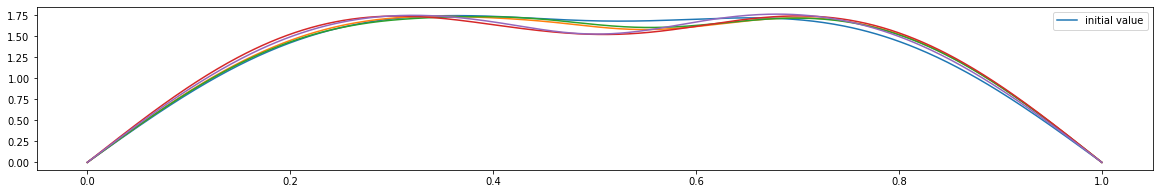

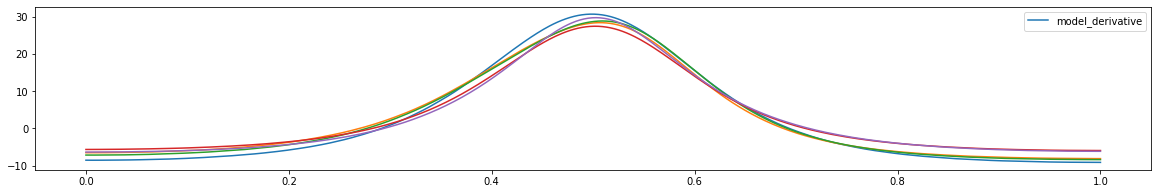

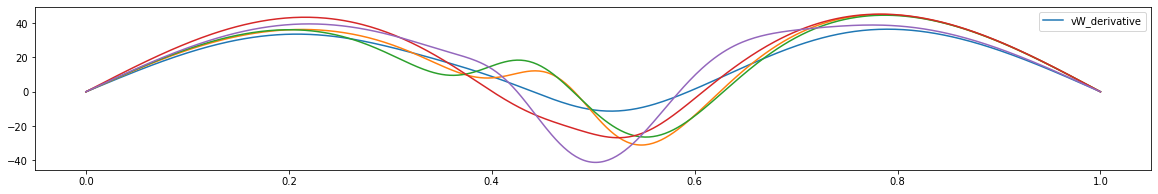

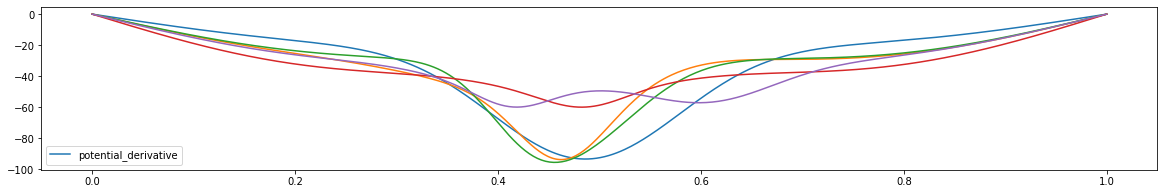

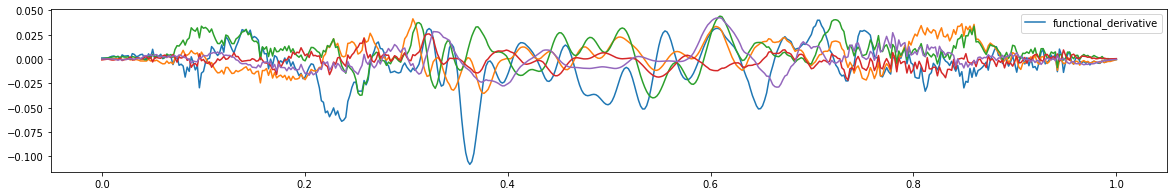

Kinetic Energy:
MAE: 0.007447402786265495
AE_std: 0.009288463399646117
AE_max: 0.13792731250586038


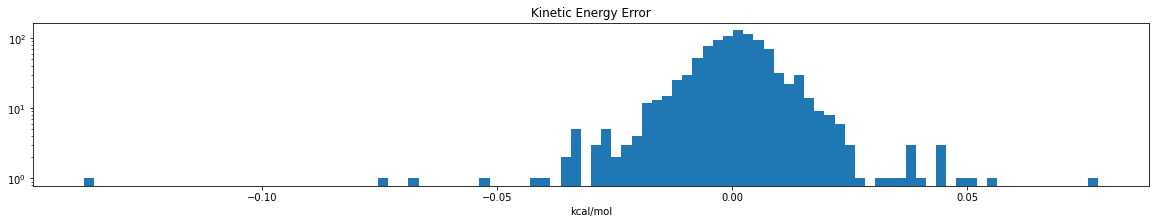

Functional Derivative:
MAE: 2.386550611282523
AE_std: 1.3600696301966952
AE_max: 19.402528787422725


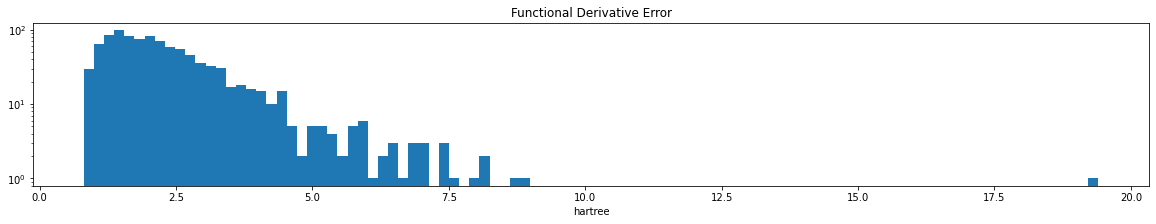

In [7]:
run_name = 'models_resnet_vW_N2_100000'
preview = 5
figsize = (20, 3)
dpi = None
kcalmol_per_hartree = 627.5094738898777
params = load_hyperparameters(file_hyperparams, run_name=run_name)

model_dir = os.path.join(base_dir, run_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

dataset = QFDataset(os.path.join(data_dir, params['dataset']), params)
dataset_train = QFDataset(os.path.join(data_dir, params['train_dataset']), params)
params['dataset_info'] = dataset.get_params(shapes=False, h=True)
h = params['dataset_info']['h']


vW_model = vWModel()

if params['model']:
    model = tf.saved_model.load(os.path.join(data_dir, params['model']))
else:
    model = lambda features: {'kinetic_energy': 0.0*integrate(features['density'], h)}

project_fd = lambda density, functional_derivative: functional_derivative
project = lambda density: density

if params['project_functional_derivative'] == 'pca':
    projection_model = LocalPCA(dataset_train.density, **params['pca_kwargs'])
    project_fd = lambda density, functional_derivative: projection_model(density, functional_derivative)
    print('pca projection of functional derivative')

if params['project'] == 'sines':
    n_basis = params['sines_n']
    basis = np.sqrt(2)*np.sin(dataset.x[np.newaxis, :]*np.pi*np.arange(1, n_basis+1)[:, np.newaxis])
    '''
    n_basis = params['projection_arg']
    basis = np.sqrt(2)*np.sin(dataset.x[np.newaxis, :]*np.pi*np.arange(1, n_basis+2)[:, np.newaxis])

    gram_schmid = np.zeros((n_basis, n_basis+1))
    gram_schmid[list(range(0, n_basis, 2)), list(range(1, n_basis+1, 2))] = 1
    gram_schmid[list(range(1, n_basis, 2)), list(range(0, n_basis-1, 2))] = range(1, n_basis, 2)
    gram_schmid[list(range(1, n_basis, 2)), list(range(2, n_basis+1, 2))] = [-i for i in range(3, n_basis+2, 2)]

    for row in range(3, n_basis, 2):
        gram_schmid[row] = gram_schmid[row] - gram_schmid[row-2]*(np.sum(gram_schmid[row]*gram_schmid[row-2])/np.sum(gram_schmid[row-2]*gram_schmid[row-2]))

    gram_schmid /= np.sqrt(np.sum(np.square(gram_schmid), axis=1)[:, np.newaxis])
    basis = np.matmul(gram_schmid, basis)

    project = lambda density, functional_derivative: dataset.h*tf.matmul(tf.matmul(basis, functional_derivative, transpose_b=True), basis, transpose_a=True)
    '''    
    project = lambda value: normalize(dataset.h*tf.matmul(tf.matmul(basis, value, transpose_b=True), basis, transpose_a=True), h)*np.sqrt(params['N'])
    print('project {} on sines basis of n={}'.format('pseudo-wavefuncion' if params['pseudo_wavefunction'] else 'density', params['sines_n']))

if params['project_functional_derivative'] == 'tangent':
    assert params['pseudo_wavefunction']
    project_fd = lambda pseudo, functional_derivative: functional_derivative - tf.expand_dims(integrate(functional_derivative*pseudo, h), axis=1)*pseudo
    print('tangential subspace projection of pseudo-wavefuncions')

if params['project'] == 'normalize':
    if params['pseudo_wavefunction']:
        project = lambda pseudo: normalize(pseudo, h)*np.sqrt(params['N'])
    else:
        project = lambda density: normalize_density(density, h)*params['N']
    print('normalize')

self_consistency_method = SelfConsistentDensity(model, vW_model, project_fd, project, params=params)
print('Model evaluated at solution for error checks:')
self_consistency_method.plot_step(dataset)
self_consistency_method.plot_performance(dataset, batch_size=params['batch_size'])

# Train

In [0]:
import time

if params['initial_density'] == 'mean':
    initial_density = np.repeat(np.expand_dims(np.mean(dataset_train.density, axis=0), axis=0), dataset.dataset_size, axis=0)
elif params['initial_density'] == 'zeroV':
    initial_density = normalize_density(np.repeat(np.sin(x[np.newaxis, :]*np.pi)**2, M, axis=0))*params['N']
elif params['initial_density'] == 'solution':
    initial_density = dataset.density

if params['pseudo_wavefunction']:
    value = tf.math.sqrt(initial_density)
else:
    value = initial_density

In [9]:
batch_size = params['batch_size']
assert dataset.dataset_size % batch_size == 0

progress = widgets.IntProgress(value=0, max=0, description='...', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

IntProgress(value=0, bar_style='info', description='...', layout=Layout(width='92%'), max=0)

In [10]:
start = time.time()
for batch in range(dataset.dataset_size // batch_size):
    progress.description = str(batch+1) + '/' + str(dataset.dataset_size // batch_size)
    self_consistency_method.train(dataset.potential[batch*batch_size:(batch+1)*batch_size], value[batch*batch_size:(batch+1)*batch_size], progress=progress)
    recordings = self_consistency_method.get_recordings()
    
    save_hdf5(os.path.join(base_dir, run_name, 'recordings_{:05d}.hdf5'.format(batch)), datasets=recordings)

duration = time.time() - start
print('duration:', duration, 'seconds')

duration: 910.1219623088837 seconds


Kinetic Energy:
MAE: 0.04658750899306649
AE_std: 0.06981970611540544
AE_max: 0.8855923436451184


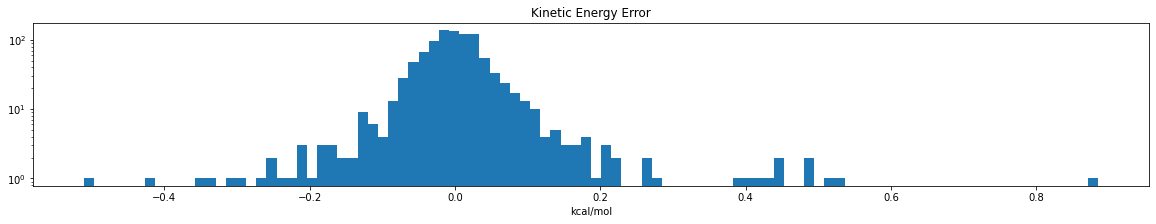

Functional Derivative:
MAE: 2.403049954406902
AE_std: 1.377272208938002
AE_max: 18.94319458830545


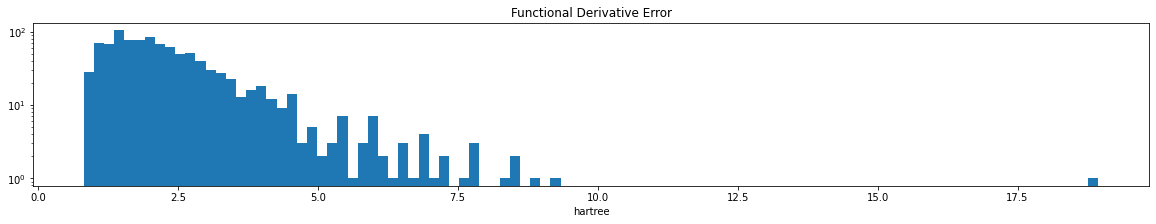

Density:
MAE: 6.284901727098059e-05
AE_std: 4.5969666371746506e-05
AE_max: 0.000552723345945063


In [11]:
recordings = {key:[] for key in params['record'].keys()}

for batch in range(dataset.dataset_size // batch_size):
    for key, value in load_hdf5(os.path.join(base_dir, run_name, 'recordings_{:05d}.hdf5'.format(batch))).items():
        recordings[key].append(value)

for key in recordings.keys():
    recordings[key] = np.concatenate(recordings[key], axis=1)

self_consistent_value = recordings['value'][-1]

self_consistency_method.plot_performance(dataset, value=self_consistent_value, batch_size=params['batch_size'])

if params['pseudo_wavefunction']:
    self_consistent_density = tf.square(self_consistent_value)
else:
    self_consistent_density = self_consistent_value

density_err = (self_consistent_density - dataset.density)
density_norm_err = integrate(np.abs(density_err), dataset.h)
print('Density:')
print('MAE:', np.nanmean(density_norm_err))
print('AE_std:', np.std(density_norm_err))
print('AE_max:', np.max(density_norm_err))

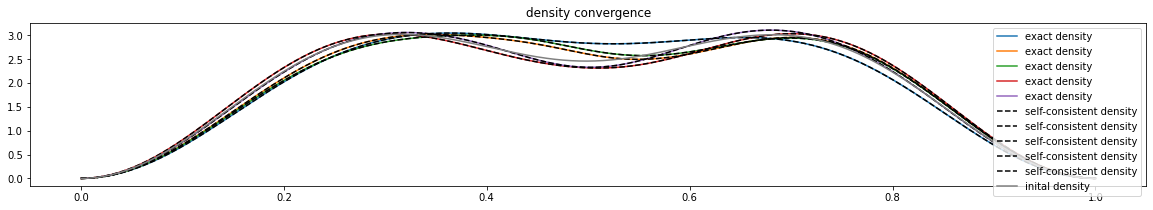

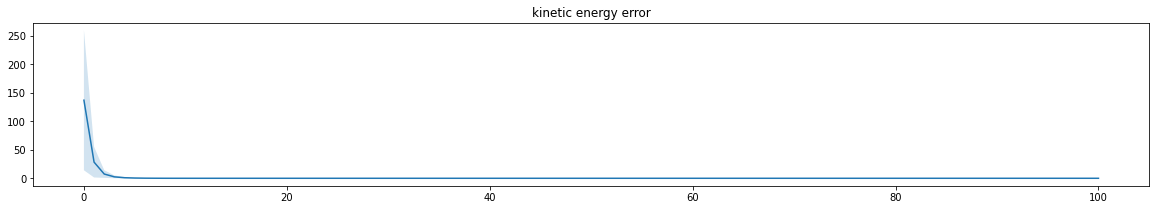

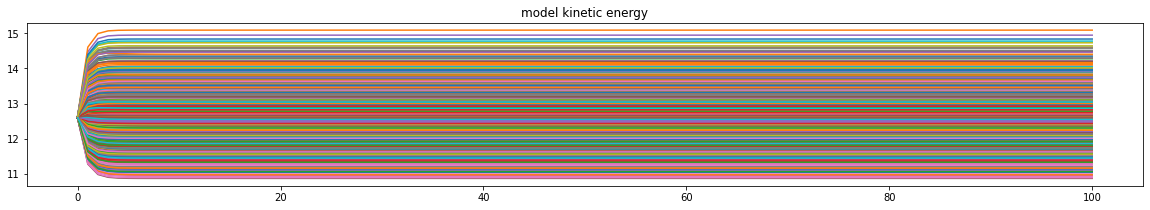

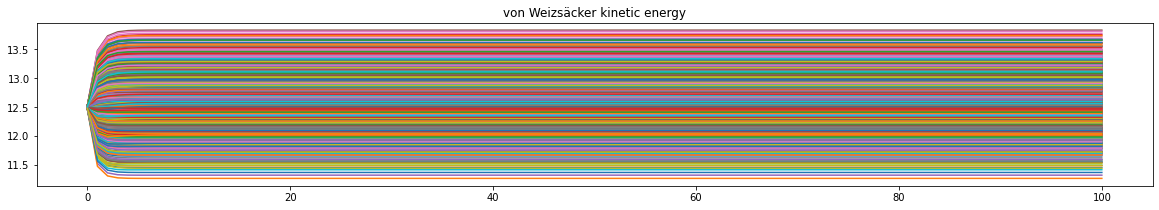

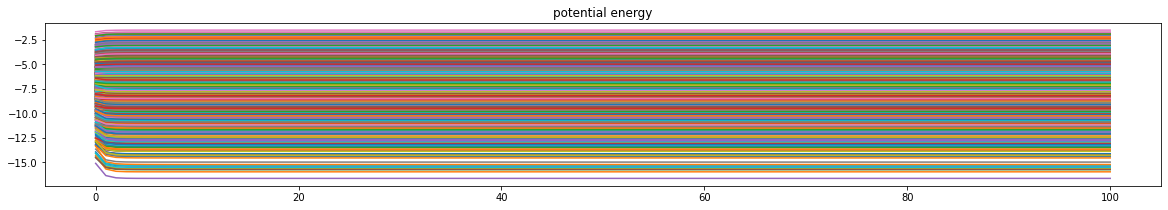

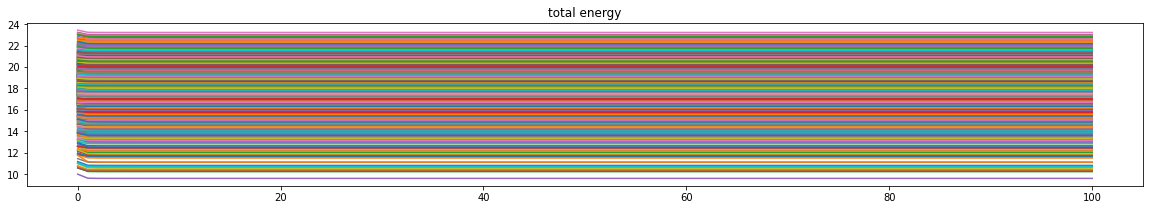

In [12]:
preview = 5
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset.x, np.transpose(dataset.density[:preview]), label='exact density')
plt.plot(dataset.x, np.transpose(self_consistent_density[:preview]), 'k--', label='self-consistent density')
plt.plot(dataset.x, np.transpose(initial_density[0:1]), 'grey', label='inital density')
plt.legend()
plt.title('density convergence')
plt.show()

model_kinetic_energy = []
kinetic_energy = []
potential_energy = []
vW_kinetic_energy = []

model_kinetic_energy_density = []
vW_kinetic_energy_density = []

for value_step in recordings['value']:
    value_step = tf.constant(value_step)

    if params['model_pseudo_wavefunction']:
        model_input = {'pseudo': tf.cast(value_step, dtype=params['model_dtype'])} if params['pseudo_wavefunction'] else {'pseudo': tf.cast(tf.math.sqrt(value_step), dtype=params['model_dtype'])}
    else:
        model_input = {'density': tf.cast(tf.square(value_step), dtype=params['model_dtype'])} if params['pseudo_wavefunction'] else {'density': tf.cast(value_step, dtype=params['model_dtype'])}
    
    model_predictions = model(model_input)

    model_kinetic_energy_step = tf.cast(model_predictions['kinetic_energy'], dtype=params['dtype'])
    vW_predictions = vW_model(value_step)
    vW_kinetic_energy_step = vW_predictions['kinetic_energy']

    if 'kinetic_energy_density' in model_predictions: 
        model_kinetic_energy_density_step = tf.cast(model_predictions['kinetic_energy_density'], dtype=params['dtype'])
        vW_kinetic_energy_density_step = vW_predictions['kinetic_energy_density']
        plot_kinetic_energy_density = True
    else:
        plot_kinetic_energy_density = False

    if params['pseudo_wavefunction']:
        potential_energy_step = integrate(tf.square(value_step)*dataset.potential, params['dataset_info']['h'])
    else:
        potential_energy_step = integrate(value_step*dataset.potential, params['dataset_info']['h'])

    model_kinetic_energy.append(model_kinetic_energy_step.numpy())
    vW_kinetic_energy.append(vW_kinetic_energy_step.numpy())
    potential_energy.append(potential_energy_step.numpy())

    if plot_kinetic_energy_density: 
        model_kinetic_energy_density.append(model_kinetic_energy_density_step.numpy())
        vW_kinetic_energy_density.append(vW_kinetic_energy_density_step.numpy())

model_kinetic_energy = np.stack(model_kinetic_energy, axis=0)
vW_kinetic_energy = np.stack(vW_kinetic_energy, axis=0)
potential_energy = np.stack(potential_energy, axis=0)

if plot_kinetic_energy_density:
    model_kinetic_energy_density = np.stack(model_kinetic_energy_density, axis=0)
    vW_kinetic_energy_density = np.stack(vW_kinetic_energy_density, axis=0)

kinetic_energy = model_kinetic_energy + params['model_subtract_von_weizsaecker']*vW_kinetic_energy

kenergies_err = np.abs(tf.expand_dims(dataset.kinetic_energy, axis=0) - kinetic_energy)*kcalmol_per_hartree
kenergies_err_mean = np.mean(kenergies_err, axis=1)
kenergies_err_std = np.std(kenergies_err, axis=1)

plt.figure(figsize=figsize, dpi=dpi)
plt.fill_between(np.arange(len(kenergies_err_mean)), kenergies_err_mean - kenergies_err_std, kenergies_err_mean + kenergies_err_std, alpha=0.2)
plt.plot(kenergies_err_mean)
#plt.ylim([0, 10])
plt.title('kinetic energy error')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(model_kinetic_energy)

plt.title('model kinetic energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(vW_kinetic_energy)
plt.title('von Weizsäcker kinetic energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(potential_energy)
plt.title('potential energy')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(potential_energy + kinetic_energy)
plt.title('total energy')
plt.show()


0.8855923436451184


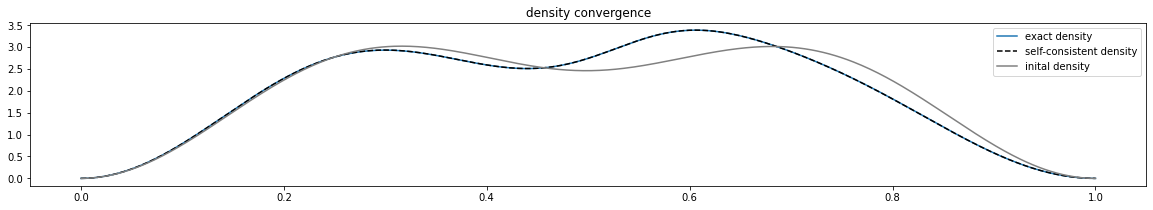

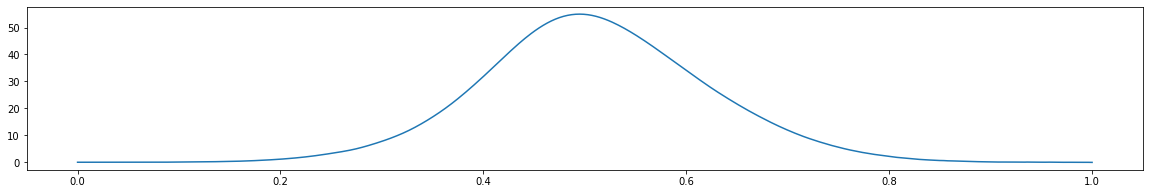

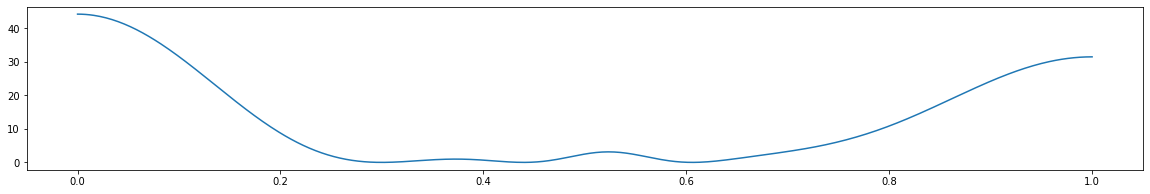

In [13]:
worst_index = np.argmax(kenergies_err[-1])
print(kenergies_err[-1][worst_index])

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset.x, np.transpose(dataset.density[worst_index:worst_index+1]), label='exact density')
plt.plot(dataset.x, np.transpose(self_consistent_density[worst_index:worst_index+1]), 'k--', label='self-consistent density')
plt.plot(dataset.x, np.transpose(initial_density[0:1]), 'grey', label='inital density')
plt.legend()
plt.title('density convergence')
plt.show()

if plot_kinetic_energy_density:
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(dataset.x, np.transpose(model_kinetic_energy_density[-1, worst_index:worst_index+1]))
    plt.show()

    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(dataset.x, np.transpose(vW_kinetic_energy_density[-1, worst_index:worst_index+1]))
    plt.show()

In [14]:
if plot_kinetic_energy_density:
    print('model_kinetic_energy_density')
    anim_plot(np.moveaxis(model_kinetic_energy_density, 2, 1), bar='Rendering')
    print('vW_kinetic_energy_density')
    anim_plot(np.moveaxis(vW_kinetic_energy_density, 2, 1), bar='Rendering')

model_kinetic_energy_density


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

vW_kinetic_energy_density


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

In [15]:
print('densities/pseudo-wavefunctions')
anim_plot(np.moveaxis(recordings['value'], 2, 1), bar='Rendering')
print('functional derivatives')
anim_plot(np.moveaxis(recordings['functional_derivative'], 2, 1), bar='Rendering')
print('model derivative')
anim_plot(np.moveaxis(recordings['model_derivative'], 2, 1), bar='Rendering')
print('von Weizsäcker derivative')
anim_plot(np.moveaxis(recordings['vW_derivative'], 2, 1), bar='Rendering')

densities/pseudo-wavefunctions


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

functional derivatives


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

model derivative


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)

von Weizsäcker derivative


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'), max=101)